# VGG之Pytorch实现
## VGG介绍
更深更大更好精度的卷积神经网络。
### 可能的选项
- 更多的全连接层  
太贵。计算量太大。
- 更多的卷积层
- 将卷积层组合成块
### VGG块
![](https://cdn.jsdelivr.net/gh/tangger2000/PicHost/img202202141742568.png)
- 3x3卷积（pad=1）  
（n层，m通道）
- 2x2最大池化层（步幅2）
- 核心思想：  
用大量的3x3卷积层堆成VGG块，然后用VGG块堆出神经网络。
- 为什么不用5x5卷积？  
试过。但是，因为5x5的计算量大，导致模型更宽；这样设计出来的模型，效果不如3x3卷积，模型更窄更深的好。
### VGG架构
![](https://cdn.jsdelivr.net/gh/tangger2000/PicHost/img202202141746479.png)
- 多个VGG块后接全连接层
- 不同次数的重复VGG块得到不同的架构的VGG-16，VGG-19,...
- 对AlexNet的最大改进：  
（1）将AlexNet中的三个连续卷积层抽出，构造成VGG块。 如下（左图变成右图）：  
![](https://cdn.jsdelivr.net/gh/tangger2000/PicHost/img202202141749709.png)
![](https://cdn.jsdelivr.net/gh/tangger2000/PicHost/img202202141750631.png)  
（2）将AlexNet最开始的那些不规则的卷积层变成规则的VGG块。
### VGG架构总结
- VGG使用可重复使用的卷积块来构建深度神经网络
- 不同的卷积块个数和超参数可以得到不同的复杂度的变种


## VGG代码实现
VGG块

In [3]:
import torch
from torch import nn
from d2l import torch as d2l

def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(
            in_channels, out_channels, kernel_size=3, padding=1
        ))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

VGG网络

In [4]:
conv_arch = ((1,64), (1,128), (2,256), (2,512), (2,512))

def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(
            num_convs, in_channels, out_channels
        ))
        in_channels = out_channels
    
    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        nn.Linear(out_channels*7*7, 4096),nn.ReLU(),
        nn.Dropout(0.5), nn.Linear(4096,4096), nn.ReLU(),
        nn.Dropout(0.5), nn.Linear(4096,10))

net = vgg(conv_arch)

观察每一层输出的形状

In [5]:
X = torch.randn(1,1,224,224)
for blk in net:
    X=blk(X)
    print(blk.__class__.__name__, 'Output shape:\t', X.shape)

Sequential Output shape:	 torch.Size([1, 64, 112, 112])
Sequential Output shape:	 torch.Size([1, 128, 56, 56])
Sequential Output shape:	 torch.Size([1, 256, 28, 28])
Sequential Output shape:	 torch.Size([1, 512, 14, 14])
Sequential Output shape:	 torch.Size([1, 512, 7, 7])
Flatten Output shape:	 torch.Size([1, 25088])
Linear Output shape:	 torch.Size([1, 4096])
ReLU Output shape:	 torch.Size([1, 4096])
Dropout Output shape:	 torch.Size([1, 4096])
Linear Output shape:	 torch.Size([1, 4096])
ReLU Output shape:	 torch.Size([1, 4096])
Dropout Output shape:	 torch.Size([1, 4096])
Linear Output shape:	 torch.Size([1, 10])


由于VGG-11比AlexNet计算量更大，因此文明构建一个通道数比较少的网络

In [6]:
ratio=4
small_conv_arch = [(pair[0], pair[1]//ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

验证模型和训练模型的函数定义

In [7]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    if isinstance(net, torch.nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
    metric = d2l.Accumulator(2)
    for X,y in data_iter:
        if isinstance(X, list):
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y=y.to(device)
        metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0]/metric[1]

def train(net, train_iter, test_iter, num_epochs, lr ,device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on',device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])

    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X,y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X,y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            metric.add(l*X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0]/metric[2]
            train_acc = metric[1]/metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

模型训练

loss 0.097, train acc 0.964, test acc 0.929
482.8 examples/sec on cuda:0


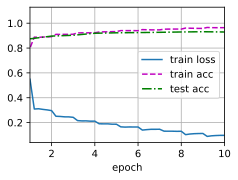

In [8]:
lr, num_epochs, batch_size = 0.05, 10 ,32
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=(224,224))
train(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())